In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
import seaborn as sb
import pygmnormalize as gmn
from scipy.cluster import hierarchy
from scipy.stats import variation
from sklearn.cluster import AgglomerativeClustering, Birch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In this notebook, the previously processed data is used on the BIRCH clustering algorithm using the data as is and after taking the top 100 PCs. Visualizations of the clustering are provided below.

# Load Data

In [ ]:
high_var_processed_test_genes = pd.read_csv('test_data_processed.csv')
high_var_train_genes = pd.read_csv('train_data_processed.csv')
test_lbl = pd.DataFrame(np.load('test_labels.csv.npy', allow_pickle = True))
train_lbl = pd.DataFrame(np.load('train_labels.csv.npy', allow_pickle = True))

In [89]:
def get_accuracy(true_labels, predicted_labels):
    accuracy = 0
    for i in range(len(true_labels)):
        if true_labels[i] == predicted_labels[i]:
            accuracy += 1
    return accuracy/len(true_labels)

In [146]:
# Map Labels
label_mapping = {'WHO II': 0, 'WHO III': 1, 'WHO IV': 2}
reverse_mapping = {0: 'WHO II', 1: 'WHO III', 2: 'WHO IV'}
mapped_labels_train = [label_mapping[x[0]] for x in train_lbl]
mapped_labels_test = [label_mapping[x[0]] for x in test_lbl]

## Unsupervised Machine Learning Method Analysis

### BIRCH - Agglomerative Hierarchical Clustering Technique
- Follows general structure of agglomerative clustering (gradually building clusters by combining smaller clusters)
- Optimized for larger datasets and (seems to) work well for multi-dimensional data
- Uses Clustering Feature (CF) and Clustering Feature Tree (CF-tree). CF is used to describe the features of clusters and the CF-tree is used to describe the clustering situation of the whole data
- Requires sphericial data as based on distance metrics 
- Hierarchial generally shown to be better for larger dimensions

### Birch Algorithm
- First pass through the data to produce rough clusters
- Second pass through the data to fix everything by taking the centroids of these clusters and only working with these
- Go through the data agin and reassign each data point to the closest centroid

In [169]:
birch_cluster = Birch(n_clusters=3, branching_factor=50)
birch_cluster.fit(high_var_train_genes)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=3,
      threshold=0.5)

In [170]:
get_accuracy(mapped_labels_train, birch_cluster.labels_)

0.5993150684931506

During Phase 4 of the algorithm, can use the centroids of the clusters as seeds and then predict the labels of the points by identifying the closest centroid

In [171]:
results = birch_cluster.predict(high_var_processed_test_genes)
get_accuracy(mapped_labels_test, results)

0.6060606060606061

### Trying PCA prior to clustering

In [188]:
# PCA before clustering; reducing from 8000+ features to 100
high_scaler = StandardScaler()
high_var_train_genes_scaled = high_scaler.fit_transform(high_var_train_genes)
pca = PCA(n_components=100)
transformed_data = pca.fit_transform(high_var_train_genes_scaled)
birch_cluster_pca = Birch(n_clusters=3, branching_factor=50)
birch_cluster_pca.fit(transformed_data)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=3,
      threshold=0.5)

In [189]:
get_accuracy(mapped_labels_train, birch_cluster_pca.labels_)

0.6061643835616438

In [190]:
high_var_test_genes_scaled = high_scaler.transform(high_var_processed_test_genes)
transformed_data_test = pca.transform(high_var_test_genes_scaled)
results_pca = birch_cluster_pca.predict(transformed_data_test)
get_accuracy(mapped_labels_test, results_pca)

0.6060606060606061

### Comparing the different Visualization Methods:
- PCA and t-SNE can both be used to visualize higher dimensional data and the clusters formed
- PCA is deterministic and tries to preserve global properties while t-SNE places neighbors next to
    each other and ignores global structures
- Selecting different values for perplexity can alter data visualization

In [129]:
def display_pca(input_data, labels, title):
    high_scaler = StandardScaler()
    input_scaled = high_scaler.fit_transform(input_data)
    
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(input_scaled)
    
    data_df = pd.DataFrame(data = transformed_data, columns = ['principal component 1', 'principal component 2'])
    class_labels_df = pd.DataFrame(labels)
    data_df = pd.concat([data_df, class_labels_df], axis = 1)
    data_df.columns = ['PC1', 'PC2', 'Grade']
    
    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(1,2,1) 
    ax.set_title(title, fontsize = 15)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    targets = ['WHO II', 'WHO III', 'WHO IV']
    colors = ['r', 'g', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = data_df['Grade'] == target
        ax.scatter(data_df.loc[indicesToKeep, 'PC1']
                   , data_df.loc[indicesToKeep, 'PC2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

In [137]:
def display_tsne(input_data, labels, title, perplexity=25):
    tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)
    X_2d = tsne.fit_transform(input_data)
    data_df = pd.DataFrame(data = X_2d)
    class_labels_df = pd.DataFrame(labels, columns=['Grade'])
    data_df = pd.concat([data_df, class_labels_df], axis = 1)
    
    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(1,2,1) 
    ax.set_title(title, fontsize=15)
    targets = [0, 1, 2]
    targets = ['WHO II', 'WHO III', 'WHO IV']
    ax.set_xlabel('Dimension 1', fontsize = 15)
    ax.set_ylabel('Dimension 2', fontsize = 15)
    for target, color in zip(targets,colors):
        indicesToKeep = data_df['Grade'] == target
        ax.scatter(data_df.loc[indicesToKeep, 0],
                   data_df.loc[indicesToKeep, 1],
                   c=color, edgecolor='k')
    ax.legend(targets)
    ax.grid()

## Projection of Training Data onto 2 Components

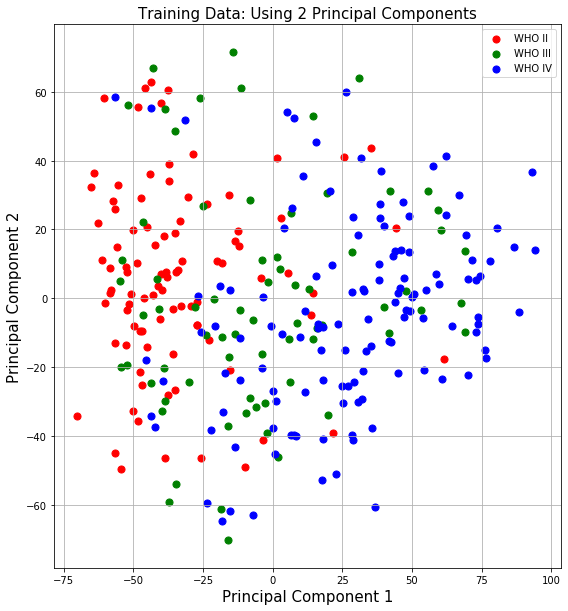

In [135]:
display_pca(high_var_train_genes, train_lbl, 'Training Data: Using 2 Principal Components')

## Visualize Training Data using t-SNE

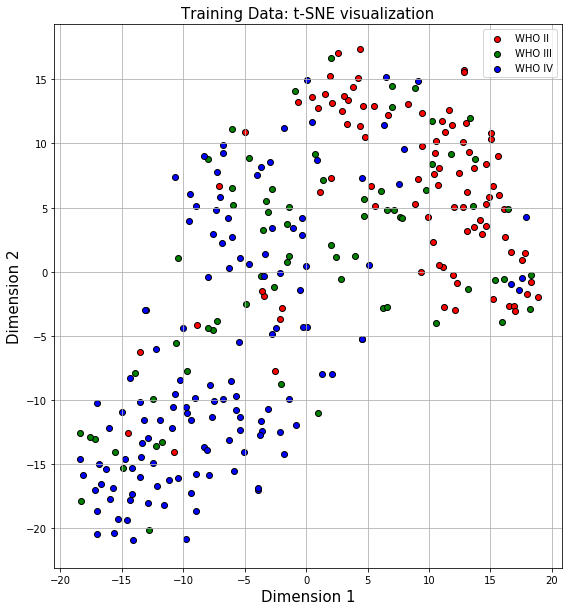

In [138]:
display_tsne(high_var_train_genes, train_lbl, 'Training Data: t-SNE visualization')

## Visualize BIRCH Clustering using PC (PCA just for visualizing)

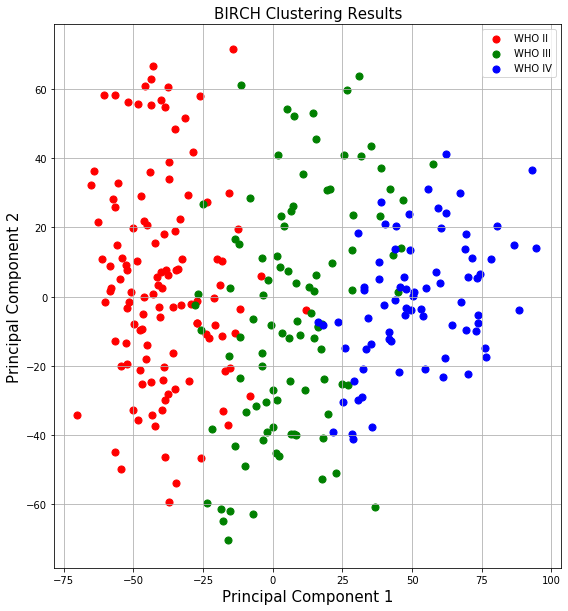

In [149]:
mapped_labels = [reverse_mapping[x] for x in birch_cluster.labels_]
display_pca(high_var_train_genes, mapped_labels, 'BIRCH Clustering Results')

## Visualize BIRCH Clustering using t-SNE (2-components)

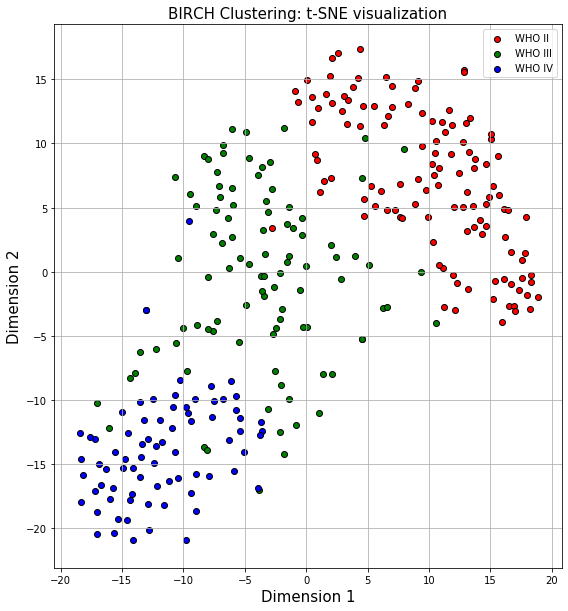

In [150]:
display_tsne(high_var_train_genes, mapped_labels, 'BIRCH Clustering: t-SNE visualization')

## Visualize Clustering Results after using only 100 components

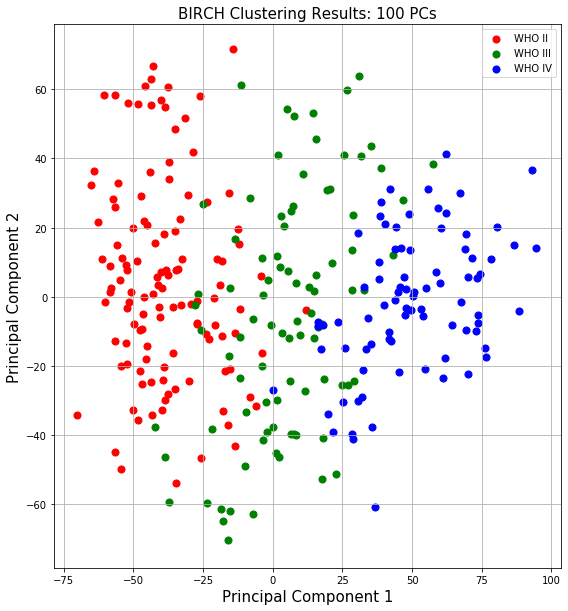

In [151]:
mapped_labels = [reverse_mapping[x] for x in birch_cluster_pca.labels_]
display_pca(high_var_train_genes, mapped_labels, 'BIRCH Clustering Results: 100 PCs')

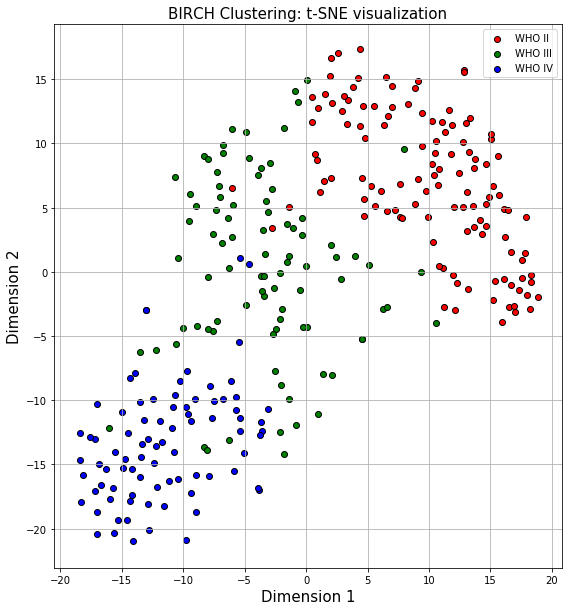

In [152]:
mapped_labels = [reverse_mapping[x] for x in birch_cluster_pca.labels_]
display_tsne(high_var_train_genes, mapped_labels, 'BIRCH Clustering: t-SNE visualization')

## Testing Set

In [110]:
# Visualize high dimensionality using PCA (should we do PCA first then cluster?)
high_scaler = StandardScaler()
high_var_train_genes_scaled = high_scaler.fit_transform(high_var_train_genes)
high_var_test_genes_scaled = high_scaler.transform(high_var_processed_test_genes)
transformed_data = pca.fit_transform(high_var_train_genes_scaled)
transformed_data_test = pca.transform(high_var_test_genes_scaled) 

In [111]:
training_plot = pd.DataFrame(data = transformed_data, columns = ['principal component 1', 'principal component 2'])
testing_plot = pd.DataFrame(data = transformed_data_test, columns = ['principal component 1', 'principal component 2'])
class_labels_df_train = pd.DataFrame(birch_cluster.labels_)
class_labels_df_test = pd.DataFrame(results_pca)
training_df = pd.concat([training_plot, class_labels_df_train], axis = 1)
training_df.columns = ['PC1', 'PC2', 'Grade']
testing_df = pd.concat([testing_plot, class_labels_df_test], axis = 1)
testing_df.columns = ['PC1', 'PC2', 'Grade']

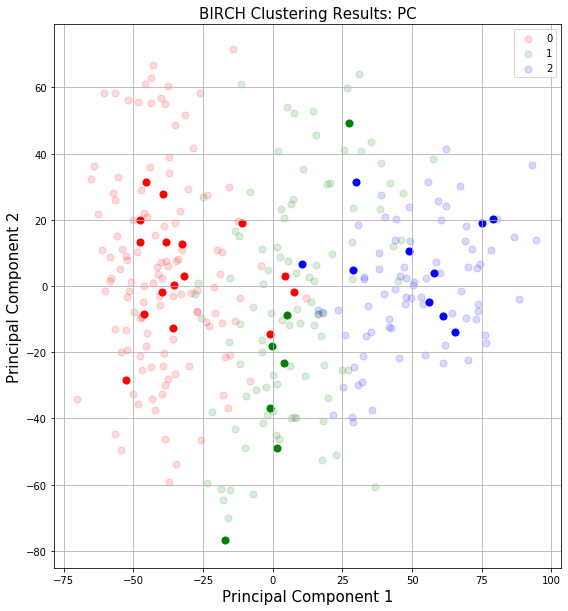

In [115]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1,2,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('BIRCH Clustering Results: PC', fontsize=15)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = training_df['Grade'] == target
    ax.scatter(training_df.loc[indicesToKeep, 'PC1']
               , training_df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50, alpha = 0.15)
for target, color in zip(targets,colors):
    indicesToKeep = testing_df['Grade'] == target
    ax.scatter(testing_df.loc[indicesToKeep, 'PC1']
               , testing_df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()